In [1]:
import pandas as pd
import geojson
import geopandas as gpd

# Convert your CSV data to GeoJSON
This script reads a CSV file containing incident data and converts it to GeoJSON format.
> I didn't commit the samples.csv due to private data.

In [ ]:
# Load the CSV data into a DataFrame
csv_file = "data/sample_incidents.csv"  # Replace with the path to your CSV file
df = pd.read_csv(csv_file)

# Create a GeoJSON FeatureCollection
features = []

for index, row in df.iterrows():
    feature = geojson.Feature(
        geometry=geojson.Point((row["Longitude"], row["Latitude"])),
        properties={
            "incident_id": index,
            "lat": row["Latitude"],
            "lon": row["Longitude"],
            "cell_id": row["cell_id"],
            "Time": row["Time"],
            "weekday": row["weekday"],
            "historical_density": row["historical_density"],
            "xd": row["xd"],
            "weighted_population": row["weighted_population"],
            "weighted_housing_units": row["weighted_housing_units"],
            "cluster_label": row["cluster_label"],
            "speed": row["speed"],
            "reference_speed": row["reference_speed"],
            "historical_average_speed": row["historical_average_speed"],
            "travel_time_minutes": row["travel_time_minutes"],
            "tempf": row["tempf"],
            "dewPt": row["dewPt"],
            "rh": row["rh"],
            "wdir_cardinal": row["wdir_cardinal"],
            "wspd": row["wspd"],
            "gust": row["gust"],
            "pressure": row["pressure"],
            "precip": row["precip"],
            "wx_phrase": row["wx_phrase"],
            "oid": row["oid"],
            "IncidentNumber": row["IncidentNumber"],
            "AlarmDate": row["AlarmDate"],
            "PSAPDate": row["PSAPDate"],
            "time_bet": row["time_bet"],
            "window_1": row["window_1"],
            "window_2": row["window_2"],
            "window_3": row["window_3"],
            "window_4": row["window_4"],
            "window_5": row["window_5"],
            "original_historical_density": row["original_historical_density"],
        },
    )
    features.append(feature)

geojson_data = geojson.FeatureCollection(features)

# Save the GeoJSON to a file
output_file = "data/incidents.geojson"  # Replace with your desired output file path
with open(output_file, "w") as f:
    geojson.dump(geojson_data, f)

print(f"GeoJSON file saved to {output_file}")

GeoJSON file saved to data/incidents.geojson


<Axes: >

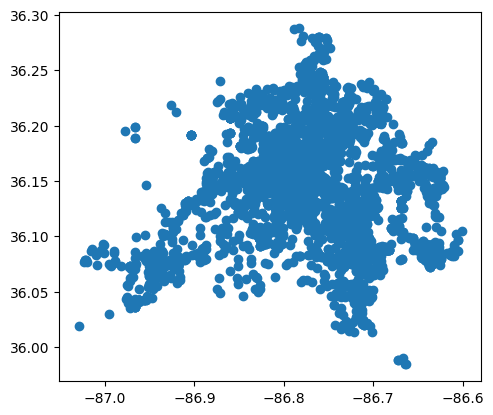

In [ ]:

# pandas show all column
pd.set_option("display.max_columns", None)
df = gpd.read_file(output_file)
df.plot()